In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sviz
import os
import zipfile
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from collections import Counter


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
"""
import subprocess
subprocess.run(["curl", "-L", "-o", "archive.zip", "https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013"])

# Set the path to the zip file
zip_file = 'archive.zip'

# Unzip the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('FACIAL')  #

# Check if files are successfully unzipped
os.listdir('FACIAL')
"""

'\nimport subprocess\nsubprocess.run(["curl", "-L", "-o", "archive.zip", "https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013"])\n'

# Data pre processing

In [4]:
# Set the path to your dataset
data_dir = 'FACIAL'

# Image transformations: Resize and Normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images between -1 and 1
])

# Load training and test data
train_data = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
test_data = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)

# Combine train_data and test_data using ConcatDataset
combined_data = ConcatDataset([train_data, test_data])

# Create a single DataLoader for both train and test data
combined_loader = DataLoader(combined_data, batch_size=64, shuffle=True)

# Check the combined dataset length and class labels
print(f"Total number of images: {len(combined_data)}")
print(train_data.classes)  # Output the class names

Total number of images: 35887
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Sample images

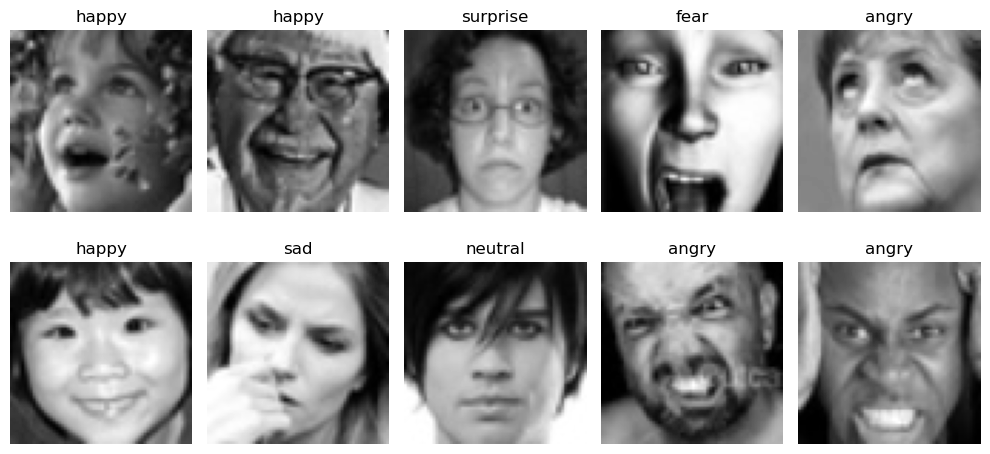

In [5]:
# Function to display a grid of images
def show_images(images, labels, class_names, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = axes[i // ncols, i % ncols]
        ax.imshow(np.squeeze(img.numpy()), cmap='gray')  # remove channel dimension
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Select random samples from the dataset
random_samples = [combined_data[i] for i in np.random.choice(len(combined_data), 10)]

# Separate images and labels
images, labels = zip(*random_samples)

# Display the images
show_images(images, labels, train_data.classes)


## Class (emotions) distribution and pixel statistics 
- Class inbalance (especially for disgust, later will apply data augmentation)

In [6]:
# Get the class indices and their corresponding class names from train_data
class_indices = train_data.class_to_idx
class_names = train_data.classes

# Initialize a Counter to count occurrences of each class label
class_counts = Counter()

# Iterate through the dataset and count each class occurrence
for _, label in combined_data:
    class_counts[label] += 1

# Map the counts to the class names
class_distribution = {class_names[idx]: count for idx, count in class_counts.items()}

# Display the class distribution
print("Class distribution:", class_distribution)

Class distribution: {'angry': 4953, 'disgust': 547, 'fear': 5121, 'happy': 8989, 'neutral': 6198, 'sad': 6077, 'surprise': 4002}


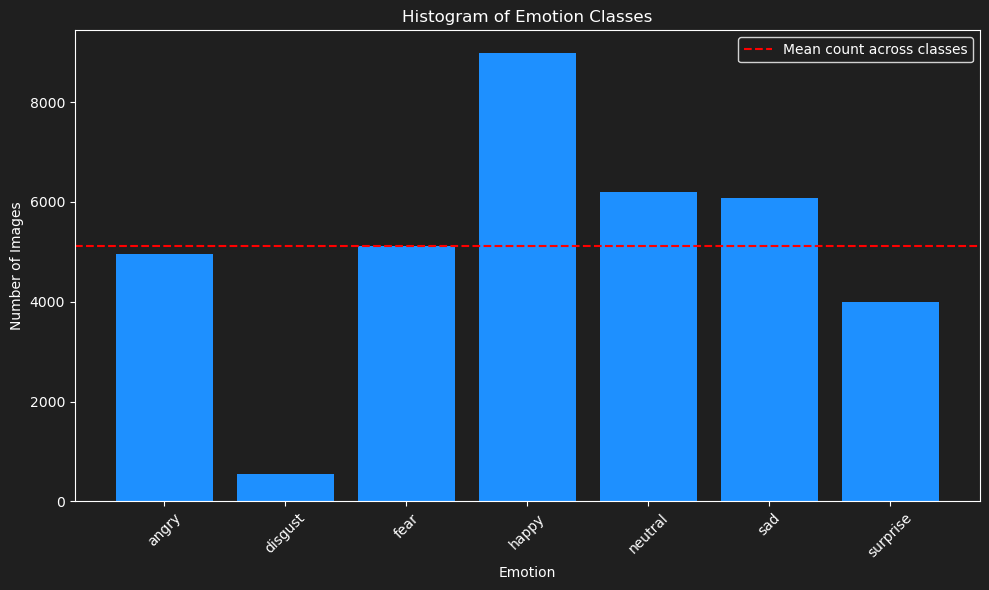

In [7]:
# Create a histogram of classes
plt.figure(figsize=(10, 6), facecolor='#1f1f1f')
plt.style.use('dark_background')
plt.bar(class_distribution.keys(), class_distribution.values(), color='#1e90ff')
plt.title('Histogram of Emotion Classes', color='white')
plt.xlabel('Emotion', color='white')
plt.ylabel('Number of Images', color='white')
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')

# Calculate the mean number of samples across groups
mean_samples = np.mean(list(class_distribution.values()))

# Add a horizontal line for the mean
plt.axhline(y=mean_samples, color='r', linestyle='--', label='Mean count across classes')
plt.legend(facecolor='#1f1f1f', edgecolor='white', labelcolor='white')

plt.gca().set_facecolor('#1f1f1f')
plt.tight_layout()
plt.show()

## Pixel intensity distribution and descriptive statistics (per class)

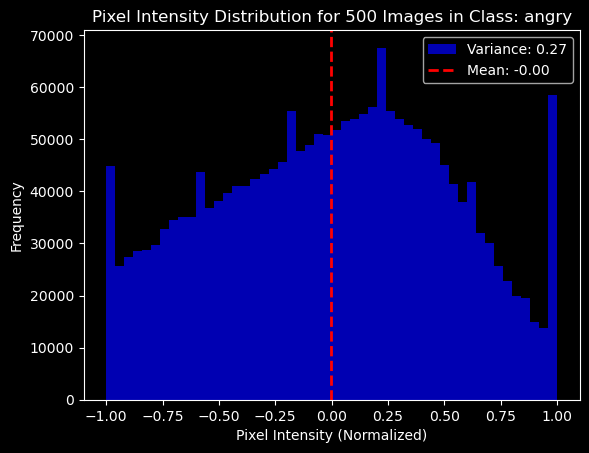

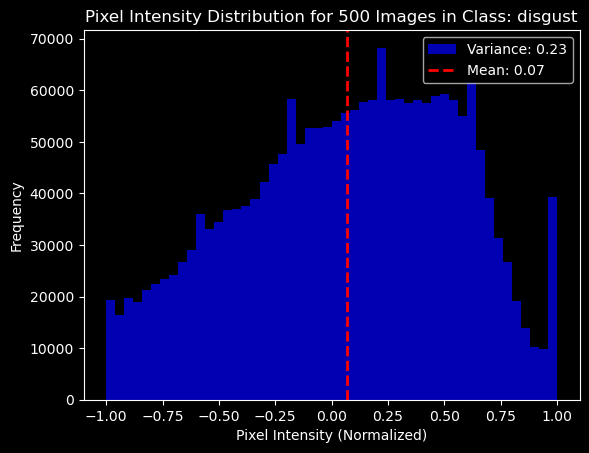

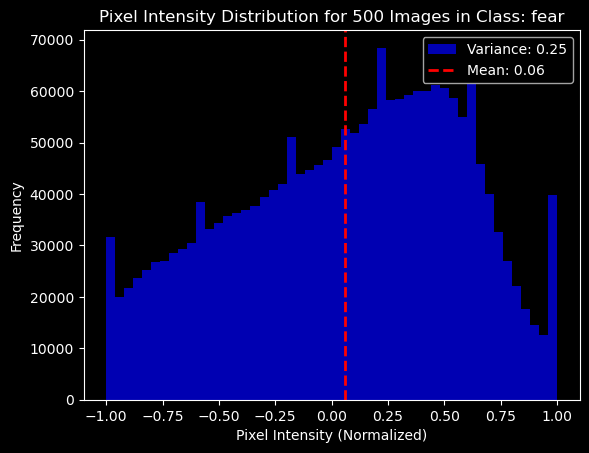

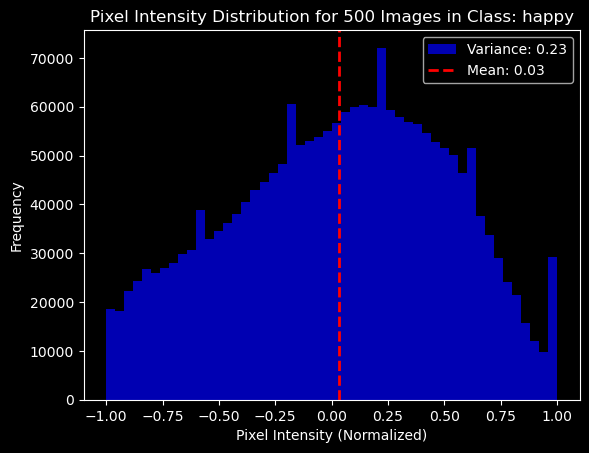

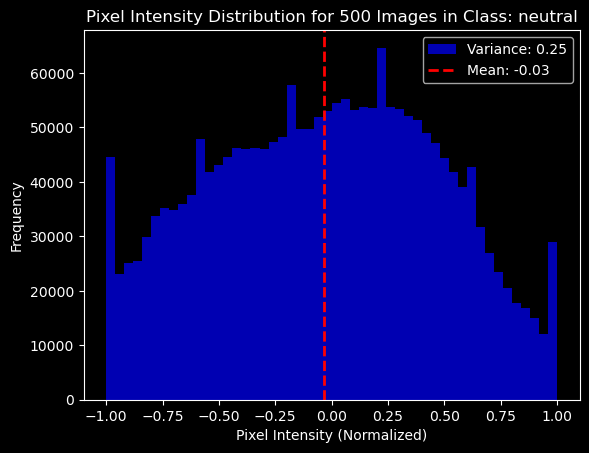

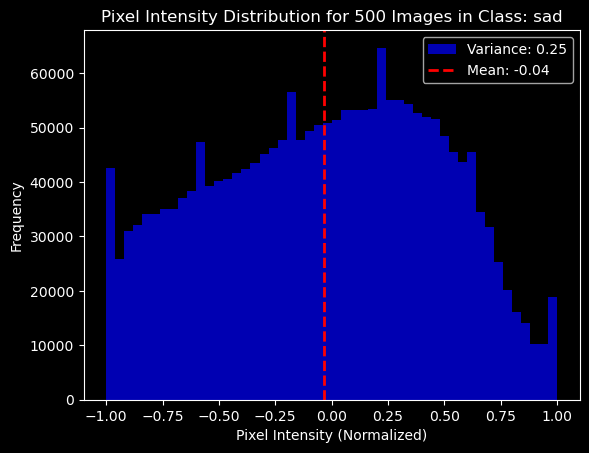

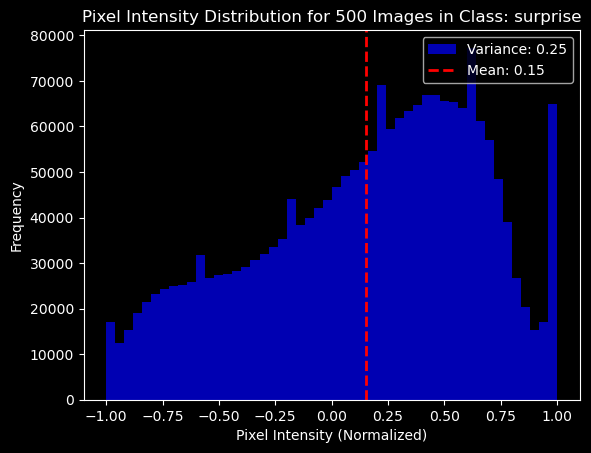

In [8]:
# Number of random samples per class
n_per_class = 500

# Dictionary to hold images by class
class_samples = {class_name: [] for class_name in class_names}

# Randomly sample 'n_per_class' images for each class
for class_idx, class_name in enumerate(class_names):  # Use enumerate to iterate over the class indices and names
    # Get indices for the images of this class
    class_indices = [i for i, (_, label) in enumerate(combined_data) if label == class_idx]
    
    # If there are fewer than 500 images in the class, take all of them
    sample_size = min(n_per_class, len(class_indices))
    
    # Randomly sample indices from the available images for this class
    random_indices = np.random.choice(class_indices, sample_size, replace=False)
    
    # Extract the images for the selected indices and add to the class_samples dictionary
    class_samples[class_name] = [combined_data[i][0] for i in random_indices]

# Plot pixel intensity distribution for each class with mean and variance
for class_name, images in class_samples.items():
    if images:  # Check if the class has any images
        # Stack images into a single tensor
        class_images = torch.stack(images)
        
        # Flatten the images to 1D for easier plotting
        pixel_values = class_images.view(-1).numpy()
        
        # Calculate mean and variance of pixel intensities
        mean_pixel_value = np.mean(pixel_values)
        variance_pixel_value = np.var(pixel_values)
        
        # Plot the histogram of pixel values for this class
        plt.hist(pixel_values, bins=50, color='blue', alpha=0.7, label=f'Variance: {variance_pixel_value:.2f}')
        
        # Add a vertical line for the mean
        plt.axvline(mean_pixel_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_pixel_value:.2f}')
        
        # Add title and labels
        plt.title(f'Pixel Intensity Distribution for {n_per_class} Images in Class: {class_name}')
        plt.xlabel('Pixel Intensity (Normalized)')
        plt.ylabel('Frequency')
        
        # Show legend with variance and mean
        plt.legend(loc='upper right')
        
        # Show the plot
        plt.show()
